In [1]:
import os
import requests
import json
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import join
from slugify import slugify
from bs4 import BeautifulSoup
from bs4.element import NavigableString

base_dir = "uog-courses"
if not os.path.exists(base_dir):
    os.makedirs(base_dir)

In [2]:
browsebysubjectarea_url = "https://www.gla.ac.uk/coursecatalogue/browsebysubjectarea/"

In [3]:
subjectareas = []
r = requests.get(browsebysubjectarea_url)
r_soup = BeautifulSoup(r.text, "lxml")

maincontent = r_soup.find('div', {'class':'maincontent'})
li_subjectareas = maincontent.find('ul').findAll('li')

for li in li_subjectareas:
    a = li.find('a')
    subjectareas.append([a.text.strip(), a.get('href')])

In [4]:
def get_subject_code(url):
    q_id = url.index('?') + len("?code=")
    amp_id = url.index('&', q_id)
    return url[q_id:amp_id]

subject, code = [], []
for sa in subjectareas:
    subject.append(sa[0])
    code.append(get_subject_code(sa[1]))

subjects = pd.DataFrame({ 'subject': subject, 'code': code })
subjects.to_csv(join(base_dir, "subjects.csv"))

In [5]:
subjects = pd.read_csv(join(base_dir, "subjects.csv"), index_col=0)
subjects.head()

,code,subject
0,ACCFIN,Accounting and Finance
1,ADED,Adult and Continuing Education
2,AMERST,American Studies
3,ARCH,Archaeology
4,ARTMED,Arts and Media Informatics


In [6]:
def get_course_code(url):
    q_id = url.index('?') + len("?code=")
    return url[q_id:]

courselist_url = "https://www.gla.ac.uk/coursecatalogue/courselist/?code=%s"
subject, code = subjects['subject'].values, subjects['code'].values

subs, codes, course_codes = [], [], []

for s in list(zip(code, subject)):
    url = courselist_url % s[0]
    r = requests.get(url)
    r_soup = BeautifulSoup(r.text, "lxml")
    maincontent = r_soup.find('div', {'class':'maincontent'})
    lis = []
    uls = maincontent.findAll('ul')
    for ul in uls:
        lis.extend(ul.findAll('li'))
    for li in lis:
        a = li.find('a')
        subs.append(s[0])
        codes.append(s[1])
        course_codes.append(get_course_code(a.get('href')))

In [10]:
with_remark = re.compile('([0-1\w\s\'\.&:\-,\(\)]+)\s\(([0-9a-zA-Z]+)\)\s([A-Z0-9]+)')
just_title = re.compile('([0-1\w\s\'\.&:\-,\(\)]+)\s([A-Z0-9]+)')

course_url = "https://www.gla.ac.uk/coursecatalogue/course/?code=%s"
details = []
for code in course_codes:
    url = course_url % code
    r = requests.get(url)
    r_soup = BeautifulSoup(r.text, "lxml")
    maincontent = r_soup.find('div', {'class':'maincontent'})
    course_title = maincontent.find('h1').text
    match_with_remark = with_remark.search(course_title)
    detail = {}
    remark = ''
    title = ''
    if match_with_remark:
        title = match_with_remark.group(1).strip()
        remark = match_with_remark.group(2).strip()
    else:
        match_just_title = just_title.search(course_title)
        if match_just_title:
            title = match_just_title.group(1).strip()
        else:
            print(url)
    detail = {slugify(a.text.split(':')[0].strip(), separator="_"): a.text.split(':')[1].strip() 
              for a 
              in maincontent.find('ul').findAll('li')}
    detail['remark'] = remark
    detail['title'] = title
    detail['code'] = code
    detail['raw'] =str(maincontent)
    details.append(detail)
    
with open(join(base_dir,'courses.json'), 'w') as outfile:
    json.dump(details, outfile, indent=4)

In [44]:
details = None
with open(join(base_dir,'courses.json'), 'r') as infile:
    details = json.load(infile)

    
different = set()
for i, detail in enumerate(details):
    if 'raw' not in detail:
        continue
    soup = BeautifulSoup(detail['raw'], "lxml")
    items = soup.find('div', {'class':'maincontent'}).findAll()
    header = None
    for item in items:
        if item.name == 'h4':
            header = slugify(item.text.strip(), separator="_")
            different.add(header)
        elif item.name == 'div' and header is not None:
            content = item.text
            detail[header] = content
            header = None
    del detail['raw']
        
print(different) 
with open(join(base_dir,'courses.json'), 'w') as outfile:
    json.dump(details, outfile, indent=4)

set(['requirements_of_entry', 'co_requisites', 'excluded_courses', 'timetable', 'intended_learning_outcomes_of_course', 'minimum_requirement_for_award_of_credits', 'short_description', 'course_aims', 'assessment'])


In [48]:
courses_df = pd.DataFrame(details)
courses_df.to_csv(join(base_dir,'courses_raw.csv'), encoding='utf-8')
courses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5202 entries, 0 to 5201
Data columns (total 20 columns):
academic_session                            5202 non-null object
assessment                                  5029 non-null object
available_to_erasmus_students               3652 non-null object
available_to_visiting_students              5202 non-null object
co_requisites                               3017 non-null object
code                                        5202 non-null object
course_aims                                 5123 non-null object
credits                                     5202 non-null object
excluded_courses                            3903 non-null object
intended_learning_outcomes_of_course        5186 non-null object
level                                       5202 non-null object
minimum_requirement_for_award_of_credits    5022 non-null object
remark                                      5202 non-null object
requirements_of_entry                       4989

In [49]:
courses_df = pd.read_csv(join(base_dir,'courses_raw.csv'), index_col = 0)

yes_transform = lambda x: x == 'Yes'

courses_df.level = pd.Categorical(values=courses_df.level, categories=["Level 1 (SCQF level 7)", 
                                                                       "Level 2 (SCQF level 8)", 
                                                                       "Level 3 (SCQF level 9)",
                                                                       "Level 4 (SCQF level 10)",
                                                                       "Level 4 (BDS, BVMS, MBChB)",
                                                                       "Level 5 (SCQF level 11)",  
                                                                       "Level 5 (BDS, BVMS, MBChB)", 
                                                                       "Level 6 (SCQF level 12)"], ordered=True)
courses_df.school = pd.Categorical(values=courses_df.school)
courses_df.available_to_erasmus_students = courses_df.available_to_erasmus_students.apply(yes_transform)
courses_df.available_to_visiting_students = courses_df.available_to_visiting_students.apply(yes_transform)
courses_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5202 entries, 0 to 5201
Data columns (total 20 columns):
academic_session                            5202 non-null object
assessment                                  4980 non-null object
available_to_erasmus_students               5202 non-null bool
available_to_visiting_students              5202 non-null bool
co_requisites                               2952 non-null object
code                                        5202 non-null object
course_aims                                 5115 non-null object
credits                                     5202 non-null int64
excluded_courses                            3848 non-null object
intended_learning_outcomes_of_course        5182 non-null object
level                                       5202 non-null category
minimum_requirement_for_award_of_credits    4858 non-null object
remark                                      552 non-null object
requirements_of_entry                       4985 non

In [50]:
reg = re.compile('([A-Z]+)')
def get_subject(value):
    match = reg.search(value)
    return match.group(1)

courses_df['subject'] = courses_df.code.apply(get_subject)
courses_df['subject'] = pd.Categorical(values=courses_df.subject)
courses_df.to_csv(join(base_dir,'courses_1.csv'))
courses_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5202 entries, 0 to 5201
Data columns (total 21 columns):
academic_session                            5202 non-null object
assessment                                  4980 non-null object
available_to_erasmus_students               5202 non-null bool
available_to_visiting_students              5202 non-null bool
co_requisites                               2952 non-null object
code                                        5202 non-null object
course_aims                                 5115 non-null object
credits                                     5202 non-null int64
excluded_courses                            3848 non-null object
intended_learning_outcomes_of_course        5182 non-null object
level                                       5202 non-null category
minimum_requirement_for_award_of_credits    4858 non-null object
remark                                      552 non-null object
requirements_of_entry                       4985 non

In [51]:
unique_levels = courses_df.level.unique()
print(unique_levels)

[Level 1 (SCQF level 7), Level 2 (SCQF level 8), Level 4 (SCQF level 10), Level 5 (SCQF level 11), Level 3 (SCQF level 9), Level 4 (BDS, BVMS, MBChB), Level 5 (BDS, BVMS, MBChB), Level 6 (SCQF level 12)]
Categories (8, object): [Level 1 (SCQF level 7) < Level 2 (SCQF level 8) < Level 3 (SCQF level 9) < Level 4 (SCQF level 10) < Level 4 (BDS, BVMS, MBChB) < Level 5 (SCQF level 11) < Level 5 (BDS, BVMS, MBChB) < Level 6 (SCQF level 12)]


In [52]:
course_counts = courses_df[['subject','level','code']]
course_counts = course_counts.sort_values(by='subject')
subjects = subjects.sort_values(by='code')

print(subjects.head())
print(course_counts.head())

     code                         subject
0  ACCFIN          Accounting and Finance
1    ADED  Adult and Continuing Education
2  AMERST                American Studies
3    ARCH                     Archaeology
4  ARTMED      Arts and Media Informatics
   subject                    level        code
0   ACCFIN   Level 1 (SCQF level 7)  ACCFIN1003
36  ACCFIN  Level 4 (SCQF level 10)  ACCFIN4044
37  ACCFIN  Level 5 (SCQF level 11)  ACCFIN5001
38  ACCFIN  Level 5 (SCQF level 11)  ACCFIN5002
39  ACCFIN  Level 5 (SCQF level 11)  ACCFIN5055


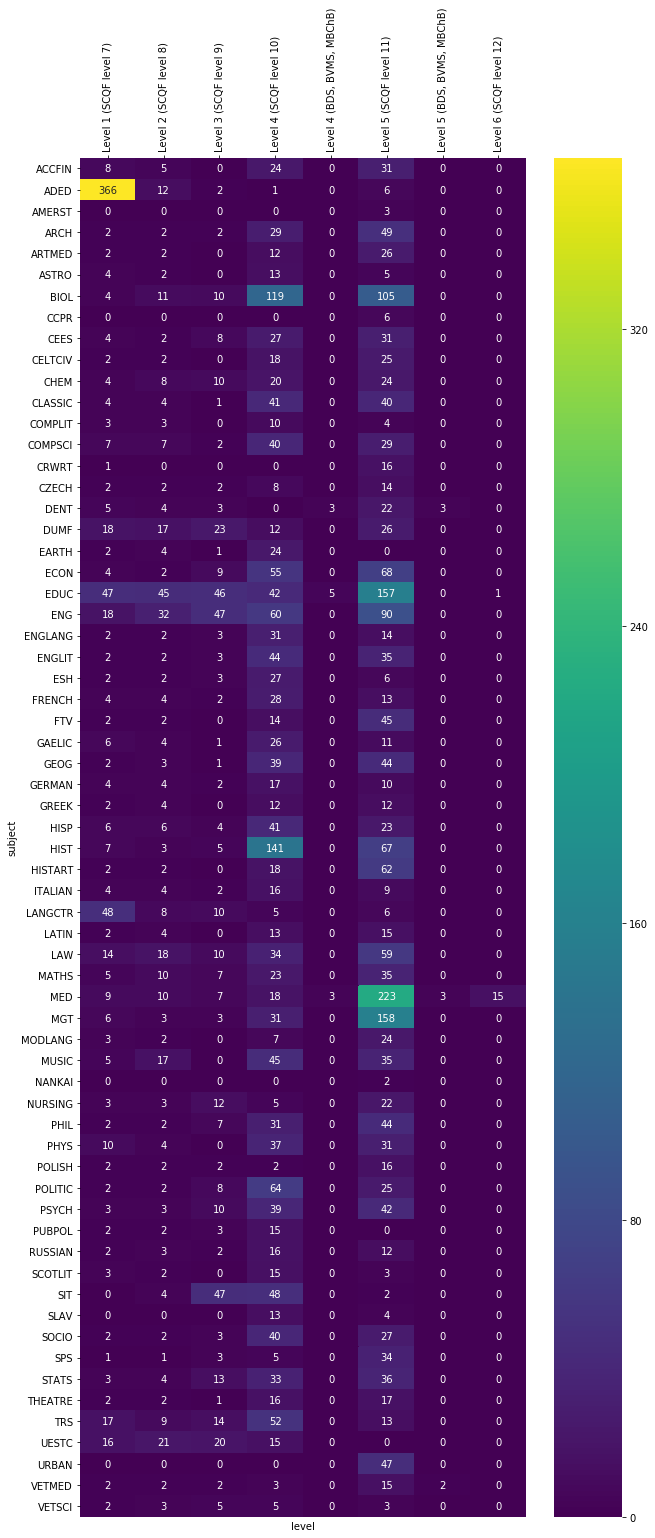

In [53]:
pivoted = pd.pivot_table(course_counts, 
                         index='subject', 
                         columns='level', 
                         values='code', 
                         aggfunc='count',
                         fill_value=0)

fig, ax = plt.subplots(figsize=(10,25))        
sns.heatmap(pivoted, annot=True, fmt="g", cmap='viridis', ax=ax)
ax.xaxis.tick_top()
plt.xticks(rotation='vertical')
plt.show()